# CIFAR10 Hands-on

-------------------------------

Notebook below shows how to manipulate images, train/test Convolutional Neural Network and visualize the learning results on CIFAR10 dataset. More information about the dataset can be found on the [Alex Krizhevsky's page](https://www.cs.toronto.edu/~kriz/cifar.html).

Before running below hands-on, recall all your knowledge about:
 - Training neural networks with SGD,
 - Convolutional Neural Networks.

You can also refer to my presentation that you can find in the root directory of this repository. HTML version with all the GIFs is available [here](https://mega.nz/#%21H4IEnZKJ%21so0Czkp8lcLWCt0o3O912WnKZBFjkvZFeJG23kITpig).

### Before you start

In below code you can find many tags that highlight places on which you can work.

**Available tags:**
 - `[TRY ME]` - places where you can change some values and try how such entries affect other components,
 - `[TODO]` - places where you have to write your own implementation for some functions/parts of code.

Let's start :)

### Prepare dataset
At first, let's prepare the dataset with all the images and classes. We'll use `torchvision` package which is great to start working with the most popular datasets with just one line of code!

In [1]:
# Let's import all the packages we will use during this hands-on
%matplotlib notebook

import os
import pickle
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import CIFAR10

Now, let's load our dataset. The CIFAR-10 dataset consists of **60000 32x32 colour images in 10 classes**, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset will download automatically into the root directory of this repository.

In [2]:
train_dataset = CIFAR10('.', train=True, download=True)
print('There are {} training pictures.'.format(len(train_dataset)))

Files already downloaded and verified
There are 50000 training pictures.


As you can see above, all of the images have already been splitted into train and test set by the `torchvision` library. With this handy trick, we can save our time working with the original files :)

Now, let's get all available labels from the metadata file stored together with the CIFAR10 images. It's a simple Python dictionary pickled into a file, so the only thing we need to do is load it and read the `label_names` field.

In [3]:
with open('./cifar-10-batches-py/batches.meta', 'rb') as metadata:
    LABELS = pickle.load(metadata)['label_names']
print('All available classes: {}.'.format(LABELS))

All available classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'].


Let's look into the dataset itself and visualise an example image.

Below image shows: dog


<IPython.core.display.Javascript object>


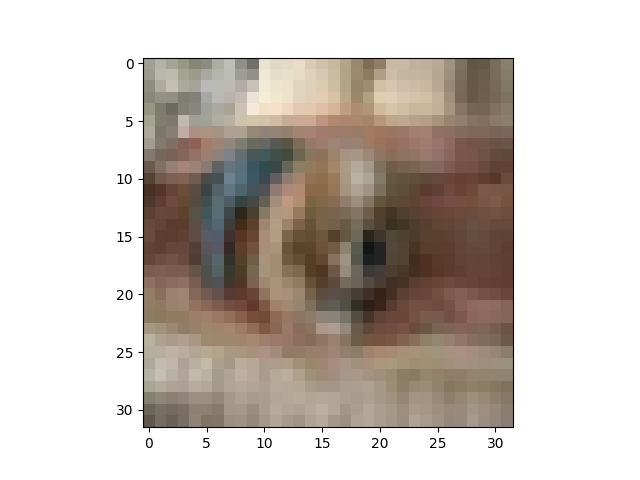

In [4]:
example_image, example_class = random.choice(train_dataset)
print('Below image shows: {}'.format(LABELS[example_class]))
plt.imshow(example_image)  # [TRY ME] Check interpolation methods, eg. 'gaussian'

### Data preprocessing

We will start our preprocessing with conversion of the images from the CIFAR10 datasets to the numpy arrays. Currently, they are PIL Images, which makes them unuseable with any of the available Machine Learning frameworks.

In [5]:
example_image, example_class = random.choice(train_dataset)
print('Types before conversion: ({}, {})'.format(type(example_image), type(example_class)))

conversion_to_numpy = lambda example: (np.array(example[0]), example[1])
train_dataset = list(map(conversion_to_numpy, train_dataset))

example_image, example_class = random.choice(train_dataset)
print('Types after conversion:  ({}, {})'.format(type(example_image), type(example_class)))

Types before conversion: (<class 'PIL.Image.Image'>, <class 'int'>)
Types after conversion:  (<class 'numpy.ndarray'>, <class 'int'>)


Once we've prepared data for further manipulation, it's time to split our initial training dataset into train and validation sets!

In [6]:
# [TRY ME] Proportion in which we should split training dataset into smaller sets
VALIDATION = 0.2

# Let's compute where we should split our training dataset
number_of_training_examples = len(train_dataset)
indices = list(range(number_of_training_examples))
splitting_point = int(np.floor(VALIDATION * number_of_training_examples))

# Shuffle all the indices, so our dataset will be equally distributed
np.random.shuffle(indices)

# Split the indices in the splitting point
train_idx, valid_idx = indices[splitting_point:], indices[:splitting_point]

# Prepare training and validation datasets with examples
training_images = [train_dataset[i][0] for i in train_idx]
training_classes = [train_dataset[i][1] for i in train_idx]
validation_images = [train_dataset[i][0] for i in valid_idx]
validation_classes = [train_dataset[i][1] for i in valid_idx]
print('Initial training dataset has: {} examples.'.format(len(train_dataset)))
print('Now, training dataset has: {} examples.'.format(len(training_images)))
print('Now, validation dataset has: {} examples.'.format(len(validation_images)))

Initial training dataset has: 50000 examples.
Now, training dataset has: 40000 examples.
Now, validation dataset has: 10000 examples.


#### Recall from CS231n course

![Data Preprocessing](./assets/data_preprocessing.jpeg)

> **Common pitfall.** An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean) must only be computed on the training data, and then applied to the validation / test data. E.g. computing the mean and subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be a mistake. Instead, the mean must be computed only over the training data and then subtracted equally from all splits (train/val/test).
http://cs231n.github.io/neural-networks-2/#datapre

Now, let's compute mean and standard deviation, which will be used to zero center and normalize dataset.

<IPython.core.display.Javascript object>


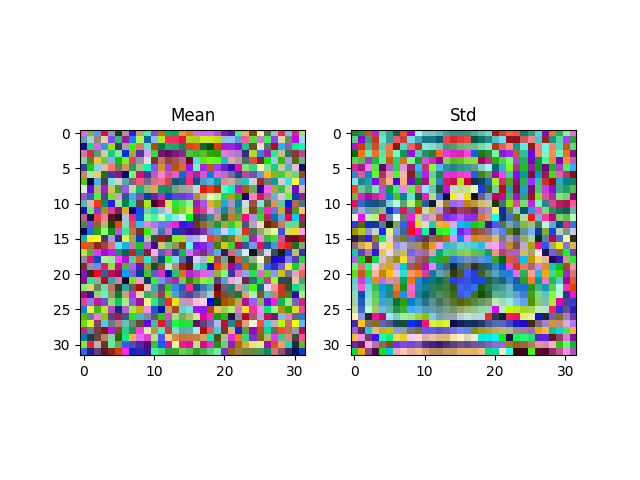

In [7]:
# Calculate mean and std dev for all images from the training dataset
MEAN_IMAGE = np.mean(training_images, axis=0)
STD_DEV_IMAGE = np.std(training_images, axis=0)

# Let's visualize them!
fig, subplots = plt.subplots(1, 2)
subplots[0].set_title('Mean')
subplots[0].imshow(MEAN_IMAGE)
subplots[1].set_title('Std')
subplots[1].imshow(STD_DEV_IMAGE)

Once, we've got mean and standard derivative let's apply them to our datasets (both training and validation dataset).

In [8]:
training_images = (training_images - MEAN_IMAGE) / STD_DEV_IMAGE
validation_images = (validation_images - MEAN_IMAGE) / STD_DEV_IMAGE

The one last thing is strictly connected with the way we will create our model. The standard approach (in the most frameworks/papers) is to use the "channels first" order, where the first dimension of the input array is the feature channel. Right now, our images have `(NUMBER_OF_IMAGES, 32, 32, 3)` shape. In order to fit them into the neural network, we've got to swap the last dimension with the second one, so our images will follow the `[BATCH, CHANNEL, IMAGE_Y, IMAGE_X]` approach.

**Remember** to always work on both the training and validation dataset! Later in this notebook, we will also apply such transformations to the test set.

In [9]:
print('Training examples before: {}'.format(training_images.shape))
print('Validation examples before: {}'.format(validation_images.shape))

training_images = np.swapaxes(training_images, 2, 3)
training_images = np.swapaxes(training_images, 1, 2)
validation_images = np.swapaxes(validation_images, 2, 3)
validation_images = np.swapaxes(validation_images, 1, 2)

print('Training examples after: {}'.format(training_images.shape))
print('Validation examples after: {}'.format(validation_images.shape))

Training examples before: (40000, 32, 32, 3)
Validation examples before: (10000, 32, 32, 3)
Training examples after: (40000, 3, 32, 32)
Validation examples after: (10000, 3, 32, 32)


Images are now ready to be used! But... our classes needs to be transformed into "one hot" format.

**One Hot** format is a way to represent our integer classes with the representation of **distribution probability** for each available class. Such values will be reconstructed by the neural network on the last layer.

_**Example one hot mapping:**_

| Class      | Previously | One Hot Representation         |
|------------|------------|--------------------------------|
| airplane   | 0          | [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] |
| automobile | 1          | [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] |
| bird       | 2          | [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] |
| ...        | ...        | ...                            |

Let's convert our classes to the One Hot format.

In [10]:
def convert_to_one_hot(old_class):
    """Convert classic integer label to the 'one hot' format"""
    one_hot_format = [0] * len(LABELS)
    one_hot_format[old_class] = 1
    return one_hot_format

training_classes = list(map(convert_to_one_hot, training_classes))
validation_classes = list(map(convert_to_one_hot, validation_classes))

Our training and validation examples are now ready to be used for training our Convolutional Neural Network!

Yay! :)

### Prepare CNN model
It's high time to prepare our Convolutional Neural Network model! We'll use PyTorch to do so :)

**Why PyTorch?** Mostely, because it's great for learning! It shows all the inside things that has to happen to train our network. Every other framework will do many of these things for us but here we've got to do it on our own. What's more, PyTorch is written in pure Python, which makes it great to experiment with. It's also Open Source, so you can look inside of the code, ask people about it (community is great) and even work on your own!

Let's prepare the model!

In [11]:
class ConvolutionalNeuralNetwork(nn.Module):
    """Our Convolutional Neural Network model"""

    def __init__(self):
        """Initialize the network components"""
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        """Run forward pass of the network"""
        # Current x: [BATCH_SIZE, 3, 32, 32]
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # Current x: [BATCH_SIZE, 32, 15, 15]
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # Current x: [BATCH_SIZE, 64, 6, 6]
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        # Current x: [BATCH_SIZE, 128, 2, 2]
        x = x.view(-1, self.get_number_of_flat_features(x))
        # Current x: [BATCH_SIZE, 512]
        x = F.relu(self.fc1(x))
        # Current x: [BATCH_SIZE, 128]
        x = F.relu(self.fc2(x))
        # Current x: [BATCH_SIZE, 128]
        x = F.softmax(self.fc3(x), dim=1)
        # Current x: [BATCH_SIZE, 10]
        return x

    def get_number_of_flat_features(self, x):
        """Calculate number of flat features"""
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Now, we've got to create our network by calling the class' initializer.

In [12]:
cnn = ConvolutionalNeuralNetwork()
print(cnn)

ConvolutionalNeuralNetwork(
  (conv1): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128)
  (fc2): Linear(in_features=128, out_features=128)
  (fc3): Linear(in_features=128, out_features=10)
)


### Train the model
Our model is ready to be trained. Before we do so, let's prepare some helper/utility functions.

First one will help us with shuffling all given examples. It's very important to shuffle images and classes in the same way, so that they'll be still coupled! We don't want to loose the dataset and mix all the labels :)

In [13]:
def shuffle_examples(images, classes):
    """Shuffle images & classes and respects they order"""
    combined = list(zip(images, classes))
    random.shuffle(combined)
    new_images, new_classes = zip(*combined)
    return new_images, new_classes

One of the metrics that we will be using is accuracy. **Accuracy** tell us how many labels were properly classified. To do so, we'll check the best class which was predicted and true label from the dataset. If they are the same, we should increase the accuracy. Accuracy will be representend as a percentage value.

That's why we need a function that tell us number of correct labels for given batch:

In [14]:
def get_number_of_correct_labels(network_output, true_labels):
    """Return number of correctly predicted labels
    
    Correct classification return 1 for given example.
    """
    predicted_classes = network_output.topk(1, 1)[1]  # Indexes for the Top-1 values
    true_classes = true_labels.topk(1, 1)[1]  # Indexes for the Top-1 values
    return predicted_classes.eq(true_classes).float().sum().data[0]

Next, we need a function that will update the figure with Loss and Accuracy on both the training and validation datasets:

In [15]:
def update_figures(figure, training_losses, validation_losses, training_accuracies, validation_accuracies):
    """Update and draw the figure with 'Loss' and 'Accuracy' plots"""
    # Clear whole figure - remove all content, titles, legend, everything!
    figure.clear()

    # 'Loss' plot
    plt.subplot(2, 1, 1)
    plt.grid(True)
    plt.title('Loss')
    plt.xlabel('Batch')
    plt.ylabel('Value')
    plt.plot(range(len(training_losses)), training_losses, '.r-', label='Training')
    plt.plot(range(len(validation_losses)), validation_losses, '.b-', label='Validation')
    
    # 'Accuracy' plot
    plt.subplot(2, 1, 2)
    plt.grid(True)
    plt.title('Accuracy')
    plt.xlabel('Batch')
    plt.ylabel('Value [%]')
    training, = plt.plot(range(len(training_accuracies)), training_accuracies, '.r-',
                         label='Training')
    validation, = plt.plot(range(len(validation_accuracies)), validation_accuracies, '.b-',
                           label='Validation')
    
    # Final rendering
    plt.tight_layout()  # Make all the above plots look neat and tidy
    plt.legend(bbox_to_anchor=(1,0), loc='lower right', bbox_transform=figure.transFigure, ncol=3)
    figure.canvas.draw()  # Update the figure

Before we define functions that will train our Convolutional Neural Network, let's define the hyperparameters for our training. These will be:
 - `BATCH_SIZE` - tell us how many examples are in a single batch,
 - `LEARNING_RATE` - tell us how much our weights will be updated using optimizer,
 - `NUMBER_OF_EPOCHS` - tell us how long should we run the training.

In [31]:
# [TRY ME] All hyper parameters for the training
BATCH_SIZE = 64
LEARNING_RATE = 0.1
NUMBER_OF_EPOCHS = 10

There are also two additional things:
 - `loss_function` - will be used to compute the loss. In our case it's Binary Cross Entropy,
 - `optimizer` - defines the opitimizer (algorithm for optimizing weights) which will be used during the training. In our case it's SGD.

Feel free to play with these things and check the results of the training :)

In [32]:
# [TRY ME] Prepare loss function with optimizer
loss_function = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.SGD(cnn.parameters(), lr=LEARNING_RATE)

Now, let's define our training function. It will take images and classes as an input and return loss and accuracy as an output. The training will use mini-batches with the size defined above.

In [18]:
def train(training_images, training_classes):
    _epoch_losses = []  # Keep losses for each batch
    _epoch_properly_classified = []  # Contains numbers of properly classified images per batch
    
    # Train our network in batches
    NUMBER_OF_TRAINING_BATCHES = int(len(training_images) / BATCH_SIZE)
    for batch_number in range(NUMBER_OF_TRAINING_BATCHES):
        if batch_number % 100 == 0:
            print('Batch #{}/{}...'.format(batch_number, NUMBER_OF_TRAINING_BATCHES))

        # Take batch of images & classes and convert them to the PyTorch Variable for further use
        batch_images = training_images[batch_number * BATCH_SIZE:(batch_number+1) * BATCH_SIZE]
        batch_images = Variable(torch.from_numpy(np.array(batch_images)).float())
        batch_classes = training_classes[batch_number * BATCH_SIZE:(batch_number+1) * BATCH_SIZE]
        batch_classes = Variable(torch.from_numpy(np.array(batch_classes)).float())
        
        # Let's train the network!
        optimizer.zero_grad()
        net_output = cnn(batch_images)
        loss = loss_function(net_output, batch_classes)
        loss.backward()
        optimizer.step()

        # Remember metrics for this batch
        _epoch_losses.append(loss.data[0])
        _epoch_properly_classified.append(get_number_of_correct_labels(net_output, batch_classes))

    # Loss for this epoch is equal to the mean of all the losses collected for each batch
    training_loss = np.mean(np.array(_epoch_losses))

    # Accuracy for this epoch is equal to all the correctly classified images
    # divided by all of the training examples
    training_accuracy = 100. * np.sum(_epoch_properly_classified) / len(training_images)

    return training_loss, training_accuracy

Validation looks (nearly) the same. And... it's acctually a copy-paste :) The only thing that has changed are not computing the gradients and not updating weights with backpopagation.

In [19]:
def validation(validation_images, validation_classes):
    _epoch_losses = []  # Keep losses for each batch
    _epoch_properly_classified = []  # Contains numbers of properly classified images per batch
    
    # Validate our network in batches
    NUMBER_OF_VALIDATION_BATCHES = int(len(validation_images) / BATCH_SIZE)
    for batch_number in range(NUMBER_OF_VALIDATION_BATCHES):
        if batch_number % 100 == 0:
            print('Batch #{}/{}...'.format(batch_number, NUMBER_OF_VALIDATION_BATCHES))

        # Take batch of images & classes and convert them to the PyTorch Variable for further use
        batch_images = validation_images[batch_number * BATCH_SIZE:(batch_number+1) * BATCH_SIZE]
        batch_images = Variable(torch.from_numpy(np.array(batch_images)).float())
        batch_classes = validation_classes[batch_number * BATCH_SIZE:(batch_number+1) * BATCH_SIZE]
        batch_classes = Variable(torch.from_numpy(np.array(batch_classes)).float())

        # Let's validate the network!
        net_output = cnn(batch_images)
        loss = loss_function(net_output, batch_classes)
        
        # Remember metrics for this batch
        _epoch_losses.append(loss.data[0])
        _epoch_properly_classified.append(get_number_of_correct_labels(net_output, batch_classes))

    # Loss for this epoch is equal to the mean of all the losses collected for each batch
    validation_loss = np.mean(np.array(_epoch_losses))

    # Accuracy for this epoch is equal to all the correctly classified images
    # divided by all of the validation examples
    validation_accuracy = 100. * np.sum(_epoch_properly_classified) / len(validation_images)
    
    return validation_loss, validation_accuracy

Our plots needs to store the history somewhere, so let's define places for them now.

In [20]:
# Clear history of the training losses and accuracies
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

Now, let's do the training!

<IPython.core.display.Javascript object>


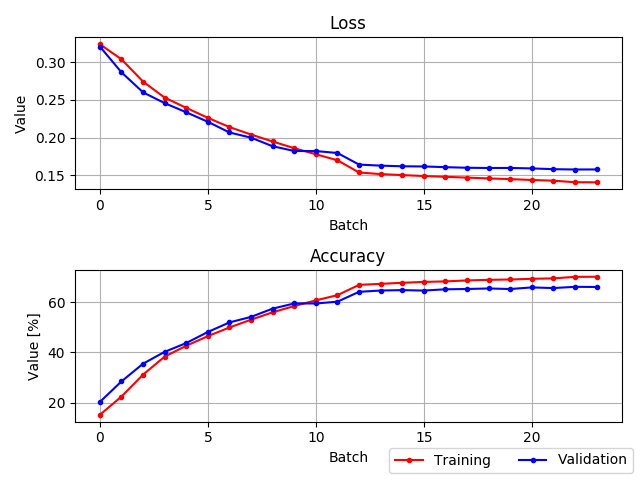

In [30]:
# Prepare figure to show losses and accuracy
plt.close()
figure = plt.figure()
update_figures(figure, training_losses, validation_losses,
               training_accuracies, validation_accuracies)

# Train the network in epochs
for epoch in range(NUMBER_OF_EPOCHS):
    print('Starting epoch #{}.'.format(epoch))
    
    # Let's shuffle all the training & validation examples
    training_images, training_classes = shuffle_examples(training_images, training_classes)
    validation_images, validation_classes = shuffle_examples(validation_images, validation_classes)

    # Train our network
    training_loss, training_accuracy = train(training_images, training_classes)
    training_losses.append(training_loss)  # History for 'Loss' plot
    training_accuracies.append(training_accuracy)  # History for 'Accuracy' plot
    
    # Debug logging and update the figures
    print(' Training loss: {:.4f}.'.format(training_loss))
    print(' Training accuracy: {:.2f}%'.format(training_accuracy))
    update_figures(figure, training_losses, validation_losses,
                   training_accuracies, validation_accuracies)

    # Validate our network
    validation_loss, validation_accuracy = validation(validation_images, validation_classes)
    validation_losses.append(validation_loss)  # History for 'Loss' plot
    validation_accuracies.append(validation_accuracy)  # History for 'Accuracy' plot

    # Debug logging and update the figures
    print(' Validation loss: {:.4f}.'.format(validation_loss))
    print(' Validation accuracy: {:.2f}%'.format(validation_accuracy))
    update_figures(figure, training_losses, validation_losses,
                   training_accuracies, validation_accuracies)
    
    # [TRY ME] Here, you can add some additional manipulation on optimizer based on
    #          training & validation metrics, eg. lower the Learning Rate if validation loss
    #          is greater than training loss (overfitting).

You can always save the current weights with below method that will store the current state of the network on disk.

In [33]:
# model_filename = 'model.pt'
# torch.save(cnn.state_dict(), os.getcwd() + '/' + model_filename)

Similar way you can always restore the state of the network with:

In [34]:
# model_filename = 'model.pt'
# cnn = ConvolutionalNeuralNetwork()
# cnn.load_state_dict(torch.load(os.getcwd() + '/' + model_filename))

### Testing our solution
To test our solution we will use the test dataset delivered with CIFAR10 itself.

In [39]:
test_dataset = CIFAR10('.', train=False)
print('There are {} test pictures.'.format(len(test_dataset)))

There are 10000 test pictures.


In order to test our neural network properly, we've got to prepare our images in the same way we've done it with the validation dataset. We'll use **the same** mean and standard deviation values as we've used previously. We'll also do **the same** transformations as on train/validation dataset (very important).

In [40]:
# Convert all images to numpy arrays
test_dataset = list(map(conversion_to_numpy, test_dataset))

# Split the test dataset into images and classes
test_images = np.array([example[0] for example in test_dataset])
test_classes = np.array([example[1] for example in test_dataset])

# Apply **the same** mean and std values to the test examples
test_images = (test_images - MEAN_IMAGE) / STD_DEV_IMAGE

# Swap the channels to match the network input ([SIZE, 32, 32, 3] -> [SIZE, 3, 32, 32])
test_images = np.swapaxes(test_images, 2, 3)
test_images = np.swapaxes(test_images, 1, 2)

# Convert all classes to "One Hot" format
test_classes = np.array(list(map(convert_to_one_hot, test_classes)))

Also, we'll get the loss and accuracy using validation method. We can do so, because it doesn't do anything more than we want now :) In the future it may happen that validation method may do something more, so be aware about it!

In [41]:
test_loss, test_accuracy = validation(test_images, test_classes)
print('Test loss: {:.4f}.'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(test_accuracy))

Batch #0/156...
Batch #100/156...
Test loss: 0.1592.
Test accuracy: 65.35%


Our model is performing somehow. It's not bad but it's also not perfect...

Even though, let's visualise some examples and verify the predicted classes on our own :)

Below image shows: dog
Our network predicted: dog
Other network predictions: [('dog', 0.58901626), ('cat', 0.29177877), ('deer', 0.066660032), ('horse', 0.028020011), ('bird', 0.0224162), ('frog', 0.0016867801), ('airplane', 0.00033383249), ('automobile', 5.0347218e-05), ('ship', 1.964261e-05), ('truck', 1.80999e-05)]


<IPython.core.display.Javascript object>


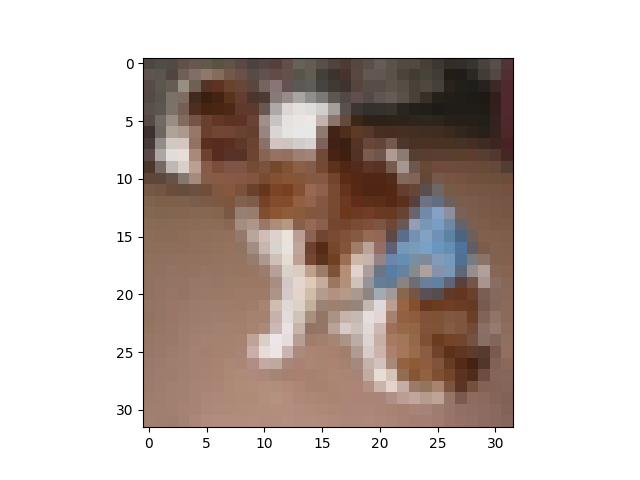

In [60]:
# Close previously opened plot - needed due to interrupting drawing loop of the previous figure
plt.close()

# Choose random image from the test dataset and prepare input/output for the network
index = random.choice(range(len(test_dataset)))
test_image, proper_class = test_images[index], test_classes[index]

# Input image has to be expanded with the batch dimension ([3, 32, 32] -> [1, 3, 32, 32])
test_image = np.expand_dims(test_image, axis=0)

# Predict class for above random image
# All the network inputs has to be PyTorch's Variables!
test_image = Variable(torch.from_numpy(test_image).float())
predicted_classes = cnn(test_image)

# Let's get classes based on "One Hot" format (which means that we are looking for the
# index/argument with the maximum value)
predicted_classes = predicted_classes.data.numpy()
predicted_class = np.argmax(predicted_classes)
proper_class = np.argmax(proper_class)

# Show the image with true/predicted classes
print('Below image shows: {}'.format(LABELS[proper_class]))
print('Our network predicted: {}'.format(LABELS[predicted_class]))
other_preditions = [(LABELS[idx], _c) for idx, _c in enumerate(predicted_classes[0])]
other_preditions = sorted(other_preditions, key=lambda predition: predition[1], reverse=True)
print('Other network predictions: {}'.format(other_preditions))
plt.imshow(test_dataset[index][0])

### Convolution visualization
There are many ways to visualize Convolutional Neural Networks. Here is the simplest one. We'll pass above test image through first two convolutional layers and see the output.

More sophisticated methods deals with looking into the weights of the convolution and try to interpret them. These are more complecated and won't be covered by this hands-on. For more information refer to [this CS231n lecture](https://www.youtube.com/watch?v=ta5fdaqDT3M).

<IPython.core.display.Javascript object>


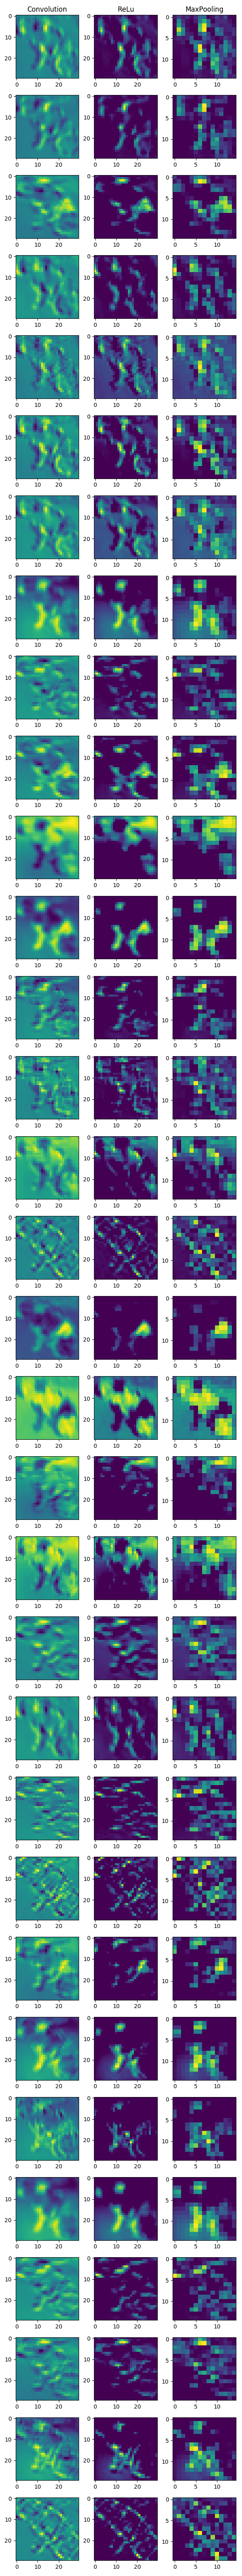

In [98]:
# Prepare figure with subplots
plt.close()
fig, subplots = plt.subplots(32, 3, figsize=(6, 64))

# Pass test image through first convolution layer
conv_pass = cnn.conv1(test_image)
relu_pass = F.relu(conv_pass)
pool_pass = F.max_pool2d(relu_pass, (2, 2))

# Fetch numpy data from PyTorch Variables
conv_pass_numpy = conv_pass[0].data.numpy()
relu_pass_numpy = relu_pass[0].data.numpy()
pool_pass_numpy = pool_pass[0].data.numpy()

# Iterate over filters and visualize each of them
for i in range(32):
    subplots[i, 0].imshow(conv_pass_numpy[i])
    subplots[i, 1].imshow(relu_pass_numpy[i])
    subplots[i, 2].imshow(pool_pass_numpy[i])

# Annotate plots
subplots[0, 0].set_title('Convolution')
subplots[0, 1].set_title('ReLu')
subplots[0, 2].set_title('MaxPooling')
fig.tight_layout()

Let's do the same for the second layer!

<IPython.core.display.Javascript object>


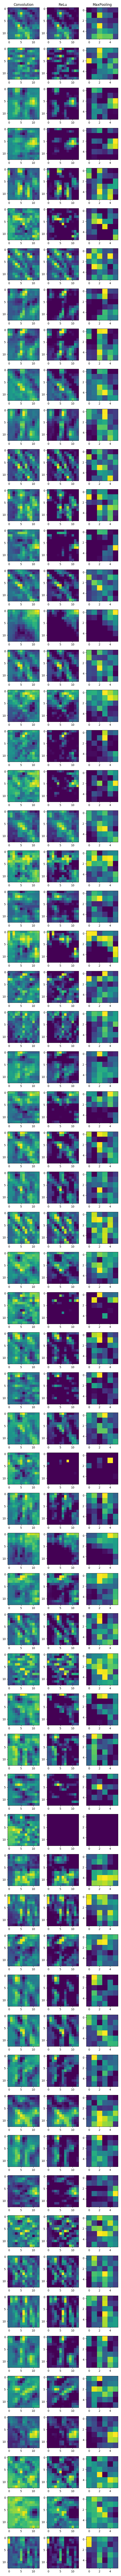

In [100]:
# Prepare figure with subplots
plt.close()
fig, subplots = plt.subplots(64, 3, figsize=(6, 128))

# Pass test image through first convolution layer
first_conv = F.max_pool2d(F.relu(cnn.conv1(test_image)), (2, 2))

# Pass test image through second convolution layer
conv_pass = cnn.conv2(first_conv)
relu_pass = F.relu(conv_pass)
pool_pass = F.max_pool2d(relu_pass, (2, 2))

# Fetch numpy data from PyTorch Variables
conv_pass_numpy = conv_pass[0].data.numpy()
relu_pass_numpy = relu_pass[0].data.numpy()
pool_pass_numpy = pool_pass[0].data.numpy()

# Iterate over filters and visualize each of them
for i in range(64):
    subplots[i, 0].imshow(conv_pass_numpy[i])
    subplots[i, 1].imshow(relu_pass_numpy[i])
    subplots[i, 2].imshow(pool_pass_numpy[i])

# Annotate plots
subplots[0, 0].set_title('Convolution')
subplots[0, 1].set_title('ReLu')
subplots[0, 2].set_title('MaxPooling')
fig.tight_layout()

### Summary
That's all for this hands-on! I hope you've learnt something useful :)

As you could see above, our model is not perfect. It's highly overfitted and has low accuracy. It now your job to make it better! Use other architectures and try to train them on your own!

In case you've got any question related with the above notebook - send me an email (you can find it on my [GitHub profile](http://github.com/jpowie01/)).

**Remember to star this repository if you like it :)**